In [2]:
import networkx as nx
from networkx import algorithms
from networkx.algorithms import community
import cudaq
from cudaq import spin
from cudaq.qis import *
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import numpy as np
import os
import time
import scipy.sparse as sp
from typing import Tuple
import json

In [3]:
# Set base directory
base_dir = '/mnt/c/Users/rames102/Desktop/Codes'

# Set the path to vrp-matrices directory
vrp_matrices_dir = os.path.join(base_dir, 'vrp_matrices_qubo/TestSet')

# Full path to the .rudy file
rudy_file_path = os.path.join(vrp_matrices_dir, 'test_pb_27_o.rudy')

# Check if the file exists
if not os.path.isfile(rudy_file_path):
    raise FileNotFoundError(f"No such file or directory: '{rudy_file_path}'")

# Parse the data contents into lines one by one
with open(rudy_file_path, 'r') as f:
    lines = f.readlines()
    # Do not save if starting with #
    for line in lines:
    #     if line.startswith('#'):
    #         continue
        # else:
            print(line)

# Generated 2024-11-28 21:58:00.746427

# Constant term of objective = 654627.08

# Diagonal terms

0 0 -68315.42

1 1 -102854.69

2 2 -102768.17

3 3 -68353.47

4 4 -68322.78

5 5 -68908.11

6 6 -34454.06

7 7 -68322.78

8 8 -102766.48

9 9 -68908.11

10 10 -34454.06

11 11 -68332.54

12 12 -68305.11

13 13 -68370.63

14 14 -34454.06

15 15 -102838.59

16 16 -68908.11

17 17 -102840.83

18 18 -102782.53

19 19 -68305.11

20 20 -68332.54

21 21 -68315.42

22 22 -34454.06

23 23 -62576.62

24 24 -62576.62

25 25 -62576.62

26 26 -62576.62

# Off-Diagonal terms

0 11  68908.11

0 12  68908.11

0 20  68908.11

0 21  68908.11

0 22  68908.11

1 15  68908.11

1 16  137816.23

1 17  68908.11

1 18  137816.23

1 25  68908.11

2 8  68908.11

2 9  137816.23

2 17  137816.23

2 18  68908.11

2 26  68908.11

3 13  68908.11

3 14  68908.11

3 19  68908.11

3 21  68908.11

3 23  68908.11

4 7  68908.11

4 10  68908.11

4 12  68908.11

4 13  68908.11

4 19  68908.11

4 20  68908.11

4 24  68908.11



In [4]:
# Convert the abiove rudy file which has the diagonal and off diagonal terms of qubo Q matrix into a qubo Q matirx

def parse_rudy_to_qubo(rudy_file: str) -> Tuple[np.ndarray, float]:
    """
    Parse a .rudy file to extract QUBO problem data.
    """
    with open(rudy_file, 'r') as file:
        lines = file.readlines()
    
    # Initialize placeholders
    constant = 0
    diagonal_terms = []
    off_diagonal_terms = []
    max_index = 0
    
    for line in lines:
        line = line.strip() # Remove leading/trailing whitespaces

        # Skip comment lines
        if not line or line.startswith("#"): # Skip empty lines and comments
            # Extract constant term
            if "Constant term of objective" in line:
                constant = float(line.split("=")[-1].strip())
            continue  # Skip further processing of this line
        
        # Parse terms
        terms = line.split() # Split by whitespace. E.g. "0 0 1.0" -> ["0", "0", "1.0"]

        # Check if the term is diagonal or off-diagonal
        if terms[0] == terms[1]:  # Diagonal terms
            i = int(terms[0])
            max_index = max(max_index, i) # Update max index
            diagonal_terms.append((i, float(terms[2]))) # Append (index, value) tuple
        else:  # Off-diagonal terms
            i, j = int(terms[0]), int(terms[1])
            max_index = max(max_index, i, j)
            off_diagonal_terms.append((i, j, float(terms[2])))
        
        print(f"Diagonal terms: {diagonal_terms}")
        print(f"Off-diagonal terms: {off_diagonal_terms}")
 
    # Construct Q matrix
    n = max_index + 1 # Number of variables (0-indexed)
    Q = np.zeros((n, n), dtype=np.float64)
    
    for i, value in diagonal_terms:
        Q[i, i] = value
    
    for i, j, value in off_diagonal_terms:
        Q[i, j] = value  # Ensure symmetry
        Q[j, i] = value  # Ensure symmetry
    
    return Q, constant

In [5]:
# Get the QUBO data

Q, constant = parse_rudy_to_qubo(rudy_file_path)

# Print or save the QUBO data
print("QUBO Matrix (Q):")
print(Q)
print("Constant (c):", constant)
print("QUBO Matrix shape:", Q.shape)


Diagonal terms: [(0, -68315.42)]
Off-diagonal terms: []
Diagonal terms: [(0, -68315.42), (1, -102854.69)]
Off-diagonal terms: []
Diagonal terms: [(0, -68315.42), (1, -102854.69), (2, -102768.17)]
Off-diagonal terms: []
Diagonal terms: [(0, -68315.42), (1, -102854.69), (2, -102768.17), (3, -68353.47)]
Off-diagonal terms: []
Diagonal terms: [(0, -68315.42), (1, -102854.69), (2, -102768.17), (3, -68353.47), (4, -68322.78)]
Off-diagonal terms: []
Diagonal terms: [(0, -68315.42), (1, -102854.69), (2, -102768.17), (3, -68353.47), (4, -68322.78), (5, -68908.11)]
Off-diagonal terms: []
Diagonal terms: [(0, -68315.42), (1, -102854.69), (2, -102768.17), (3, -68353.47), (4, -68322.78), (5, -68908.11), (6, -34454.06)]
Off-diagonal terms: []
Diagonal terms: [(0, -68315.42), (1, -102854.69), (2, -102768.17), (3, -68353.47), (4, -68322.78), (5, -68908.11), (6, -34454.06), (7, -68322.78)]
Off-diagonal terms: []
Diagonal terms: [(0, -68315.42), (1, -102854.69), (2, -102768.17), (3, -68353.47), (4, -683

In [6]:
print("QUBO Matrix (Q):", Q)

QUBO Matrix (Q): [[ -68315.42       0.         0.         0.         0.         0.
        0.         0.         0.         0.         0.     68908.11
    68908.11       0.         0.         0.         0.         0.
        0.         0.     68908.11   68908.11   68908.11       0.
        0.         0.         0.  ]
 [      0.   -102854.69       0.         0.         0.         0.
        0.         0.         0.         0.         0.         0.
        0.         0.         0.     68908.11  137816.23   68908.11
   137816.23       0.         0.         0.         0.         0.
        0.     68908.11       0.  ]
 [      0.         0.   -102768.17       0.         0.         0.
        0.         0.     68908.11  137816.23       0.         0.
        0.         0.         0.         0.         0.    137816.23
    68908.11       0.         0.         0.         0.         0.
        0.         0.     68908.11]
 [      0.         0.         0.    -68353.47       0.         0.
        0. 

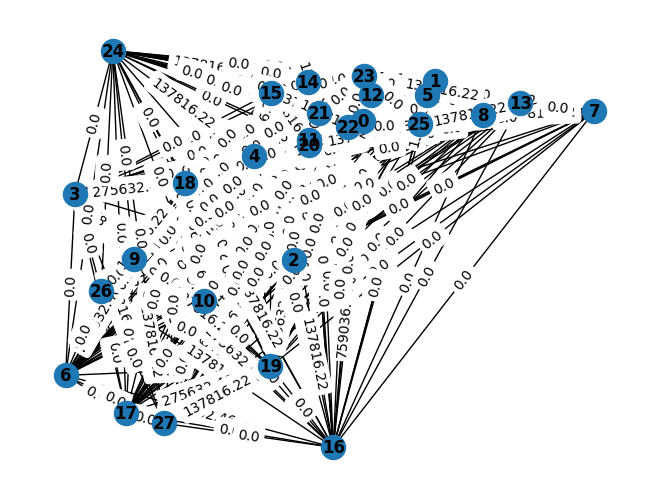

In [7]:
def qubo_to_maxcut(Q):
    n = Q.shape[0]
    G = nx.complete_graph(n + 1)
    
    # Define weights for edges in Kn+1
    for i in range(1, n + 1):
        for j in range(1, n + 1):
            if i != j:
                G[i][j]['weight'] = Q[i-1, j-1] + Q[j-1, i-1]
    
    for i in range(1, n + 1):
        G[0][i]['weight'] = sum(Q[i-1, j] + Q[j, i-1] for j in range(n))
    
    return G

# plot the graph G as a networkx graph with edge weights
G = qubo_to_maxcut(Q)
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [8]:
# Identifying and setting target

targets = cudaq.get_targets()
# for target in targets: 
#    print(target)
cudaq.set_target("qpp-cpu") # nvidia-fp64
# cudaq.set_target("nvidia", option="mqpu")
target = cudaq.get_target()
# num_qpus = target.num_qpus()
# print("Number of GPUs:", num_qpus)

In [9]:
# # Graph Definition

sampleGraph3 = qubo_to_maxcut(Q)

# print only the diagonal elements of the Q matrix along with the indices
print("Diagonal elements of Q matrix:")
for i in range(Q.shape[0]):
    print(f"Q[{i}, {i}] = {Q[i, i]}")

print("Graph nodes:", sampleGraph3.nodes)
print("Graph edges:", sampleGraph3.edges)
print("Graph edge weights:", nx.get_edge_attributes(sampleGraph3, 'weight'))

Diagonal elements of Q matrix:
Q[0, 0] = -68315.42
Q[1, 1] = -102854.69
Q[2, 2] = -102768.17
Q[3, 3] = -68353.47
Q[4, 4] = -68322.78
Q[5, 5] = -68908.11
Q[6, 6] = -34454.06
Q[7, 7] = -68322.78
Q[8, 8] = -102766.48
Q[9, 9] = -68908.11
Q[10, 10] = -34454.06
Q[11, 11] = -68332.54
Q[12, 12] = -68305.11
Q[13, 13] = -68370.63
Q[14, 14] = -34454.06
Q[15, 15] = -102838.59
Q[16, 16] = -68908.11
Q[17, 17] = -102840.83
Q[18, 18] = -102782.53
Q[19, 19] = -68305.11
Q[20, 20] = -68332.54
Q[21, 21] = -68315.42
Q[22, 22] = -34454.06
Q[23, 23] = -62576.62
Q[24, 24] = -62576.62
Q[25, 25] = -62576.62
Q[26, 26] = -62576.62
Graph nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Graph edges: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (1, 2), (1, 3), (1, 4), (

In [10]:
# Define a function to generate the Hamiltonian for a weighted max cut problem using the graph G

def hamiltonian_max_cut(sources : List[int], targets : List[int], weights : List[float]): 
    """Hamiltonian for finding the max cut for the graph  with edges defined by the pairs generated by source and target edges
        
    Parameters
    ----------
    sources: List[int] 
        list of the source vertices for edges in the graph
    targets: List[int]
        list of the target vertices for the edges in the graph
    weights : List[float]
        list of the weight of the edge determined by the source and target with the same index
    Returns
    -------
    cudaq.SpinOperator
        Hamiltonian for finding the max cut of the graph defined by the given edges
    """
    hamiltonian = 0
    # Since our vertices may not be a list from 0 to n, or may not even be integers,
    
    for i in range(len(sources)):
        # Add a term to the Hamiltonian for the edge (u,v)
        qubitu = sources[i]
        qubitv = targets[i]
        edge_weight = weights[i]
        hamiltonian += 0.5*edge_weight*(spin.z(qubitu)*spin.z(qubitv)-spin.i(qubitu)*spin.i(qubitv))
    
    return hamiltonian

In [11]:
# QAOA kernels

# Problem kernel
@cudaq.kernel
def qaoaProblem(qubit_0 : cudaq.qubit, qubit_1 : cudaq.qubit, alpha : float):
    """Build the QAOA gate sequence between two qubits that represent an edge of the graph
    Parameters
    ----------
    qubit_0: cudaq.qubit
        Qubit representing the first vertex of an edge
    qubit_1: cudaq.qubit
        Qubit representing the second vertex of an edge
    alpha: float
        Free variable

    """
    x.ctrl(qubit_0, qubit_1)
    rz(2.0*alpha, qubit_1)
    x.ctrl(qubit_0, qubit_1)

# Mixer kernel
@cudaq.kernel
def qaoaMixer(qubit_0 : cudaq.qubit, beta : float):
    """Build the QAOA gate sequence that is applied to each qubit in the mixer portion of the circuit
    Parameters
    ----------
    qubit_0: cudaq.qubit
        Qubit
    beta: float
        Free variable

    """
    rx(2.0*beta, qubit_0)

In [12]:
# Define the QAOA circuit: # The QAOA circuit for max cut depends on the structure of the graph!

@cudaq.kernel
def kernel_qaoa(qubit_count :int, layer_count: int, edges_src: List[int], edges_tgt: List[int], thetas : List[float]):
    """Build the QAOA circuit for max cut of the graph with given edges and nodes
    Parameters
    ----------
    qubit_count: int
        Number of qubits in the circuit, which is the same as the number of nodes in our graph
    layer_count : int
        Number of layers in the QAOA kernel
    edges_src: List[int]
        List of the first (source) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    edges_tgt: List[int]
        List of the second (target) node listed in each edge of the graph, when the edges of the graph are listed as pairs of nodes
    thetas: List[float]
        Free variables to be optimized

    """

    # Allocate qubits
    qreg = cudaq.qvector(qubit_count)

    # Placing qubits in superposition
    h(qreg)

    # Each layer has two components: the problem kernel and the mixer
    for i in range(layer_count):
        # Add the problem kernel to each layer
        for edge in range(len(edges_src)):
            qubitu = edges_src[edge]
            qubitv = edges_tgt[edge]
            qaoaProblem(qreg[qubitu], qreg[qubitv], thetas[i])
        # Add mixer kernel to each layer
        for j in range(qubit_count):
            qaoaMixer(qreg[j], thetas[layer_count + i])          

In [13]:
# Find the optimal parameters for the QAOA circuit using classical optimization

def find_optimal_parameters(G, layer_count, seed):
    """Function for finding the optimal parameters of QAOA for the max cut of a graph
    Parameters
    ----------
    G: networkX graph 
        Problem graph whose max cut we aim to find
    layer_count : int 
        Number of layers in the QAOA circuit
    seed : int
        Random seed for reproducibility of results
        
    Returns
    -------
    list[float]
        Optimal parameters for the QAOA applied to the given graph G
    """
    parameter_count: int = 2 * layer_count

    # Problem parameters
    nodes = sorted(list(nx.nodes(G)))
    qubit_src = []
    qubit_tgt = []
    weights = []
    for u, v in nx.edges(G):
        # We can use the index() command to read out the qubits associated with the vertex u and v.
        qubit_src.append(nodes.index(u))
        qubit_tgt.append(nodes.index(v))
        weights.append(G.edges[u,v]['weight'])                                           
    # The number of qubits we'll need is the same as the number of vertices in our graph
    qubit_count : int = len(nodes)
    # Each layer of the QAOA kernel contains 2 parameters
    parameter_count : int = 2*layer_count
    
    # Specify the optimizer and its initial parameters. 
    optimizer = cudaq.optimizers.NelderMead()
    np.random.seed(seed)
    cudaq.set_random_seed(seed)
    optimizer.initial_parameters = np.random.uniform(-np.pi, np.pi,
                                                     parameter_count)   

    # Pass the kernel, spin operator, and optimizer to `cudaq.vqe`.
    optimal_expectation, optimal_parameters = cudaq.vqe(
        kernel=kernel_qaoa,
        spin_operator=hamiltonian_max_cut(qubit_src, qubit_tgt, weights),
        argument_mapper=lambda parameter_vector: (qubit_count, layer_count, qubit_src, qubit_tgt, parameter_vector),
        optimizer=optimizer,
        parameter_count=parameter_count)

    return optimal_parameters

In [14]:
def qaoa_for_graph(G, layer_count, shots, seed):
    """Function for finding the max cut of a graph using QAOA

    Parameters
    ----------
    G: networkX graph
        Problem graph whose max cut we aim to find
    layer_count : int
        Number of layers in the QAOA circuit
    shots : int
        Number of shots in the sampling subroutine
    seed : int
        Random seed for reproducibility of results

    Returns
    -------
    str
        Binary string representing the max cut coloring of the vertinces of the graph
    """
    if nx.number_of_nodes(G) ==1 or nx.number_of_edges(G) ==0:
        # The first condition implies the second condition so we really don't need
        # to consider the case nx.number_of_nodes(G) ==1
        results = ''
        for u in list(nx.nodes(G)):
            np.random.seed(seed)
            random_assignment = str(np.random.randint(0, 1))
            results+=random_assignment

    else:
        parameter_count: int = 2 * layer_count

        # Problem parameters
        nodes = sorted(list(nx.nodes(G)))
        qubit_src = []
        qubit_tgt = []
        for u, v in nx.edges(G):
            # We can use the index() command to read out the qubits associated with the vertex u and v.
            qubit_src.append(nodes.index(u))
            qubit_tgt.append(nodes.index(v))
        # The number of qubits we'll need is the same as the number of vertices in our graph
        qubit_count : int = len(nodes)
        # Each layer of the QAOA kernel contains 2 parameters
        parameter_count : int = 2*layer_count

        optimal_parameters = find_optimal_parameters(G, layer_count, seed)

        # Print the optimized parameters
        print("Optimal parameters = ", optimal_parameters)

        # Sample the circuit
        counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, qubit_src, qubit_tgt, optimal_parameters, shots_count=shots)
        print('Outcome = ',counts)
        results = str(counts)
        
    return results

In [18]:
def subgraph_solution(G, key, layer_count, global_graph,seed ):
    """
    Recursively finds max cut approximations of the subgraphs of the global_graph
    Parameters
    ----------
    G : networkX.Graph
        Graph with vertex color attributes
    key : str
        name of subgraph
    vertex_limit : int
        maximum size of graph to which QAOA will be applied directly
    subgraph_limit : int
        maximum size of the merger graphs, or maximum number of subgraphs in any subgraph decomposition
    layer_count : int
        number of layers in QAOA circuit for finding max cut solutions
    global_graph : networkX.Graph
        the parent graph
    seed : int
        random seed for reproducibility

    Returns
    -------
    str
        returns string of 0s and 1s representing colors of vertices of global_graph for the approx max cut solution
    """
    # create a results dictionary to store the results of the subgraph solutions
    results = {}
    seed +=1
    # Find the max cut of G using QAOA, provided G is small enough
    print('Working on finding max cut approximations for ',key)

    result =qaoa_for_graph(G, seed=seed, shots = 10000, layer_count=layer_count)
    results[key]=result
    # color the global graph's nodes according to the results
    nodes_of_G = sorted(list(G.nodes()))
    for u in G.nodes():
        global_graph.nodes[u]['color']=results[key][nodes_of_G.index(u)]
    return result

In [ ]:
num_qubits = 14 # max number of qubits allowed in a quantum circuit
layer_count = 1 # Layer count for the QAOA max cut
seed = 101

cut_results = subgraph_solution(sampleGraph3, 'Global', layer_count, sampleGraph3, seed)

In [ ]:
# Input string
input_string = cut_results

# Remove "Outcome =" and clean braces and extra characters
cleaned_string = input_string.replace("Outcome = ", "").replace("{", "").replace("}", "").strip()

# Split into key-value pairs
pairs = cleaned_string.split()

# Create the dictionary and keep binary strings with leading zeros
binary_dict = {str(i): pair.split(':')[0] for i, pair in enumerate(pairs)}

print(binary_dict)

In [ ]:
def calculate_cut_values(graph, solutions):
    """
    Evaluate the cut values using the MaxCut formulation.
    
    Parameters:
        graph (nx.Graph): The graph with edges and weights.
        solutions (dict): Dictionary of solutions where keys are solution IDs
                          and values are binary strings representing partitions.
    
    Returns:
        dict: Dictionary mapping solution IDs to their cut values.
    """
    cut_values = {}
    for sol_id, binary_string in solutions.items():
        x = list(map(int, binary_string))  # Convert binary string to list of integers
        cut_value = 0
        for u, v, data in graph.edges(data=True):
            w_uv = data.get('weight', 1)  # Default weight is 1 if not provided
            cut_value += w_uv * (x[u] + x[v] - 2 * x[u] * x[v])
        cut_values[sol_id] = cut_value
    return cut_values

# Compute cut values
cut_values = calculate_cut_values(sampleGraph3, binary_dict)
print(cut_values)


In [ ]:
def maxcut_to_qubo(maxcut_values, edge_weights, q_diag, q_off_diag):
    """
    Convert MaxCut values to QUBO values.
    
    Parameters:
        maxcut_values (dict): MaxCut values {solution_id: maxcut_value}.
        edge_weights (dict): Weights of edges {edge: weight}.
        q_diag (list): Diagonal elements q_{ii}.
        q_off_diag (dict): Off-diagonal elements q_{ij}.

    Returns:
        dict: QUBO values {solution_id: qubo_value}.
    """
    # Step 1: Compute the total weight of edges
    total_weight = sum(edge_weights.values())
    
    # Step 2: Compute the constant C
    C = (1/4) * (
        total_weight + 2 * sum(q_diag) + sum(q_off_diag.values())
    )
    
    # Step 3: Compute QUBO values
    qubo_values = {}
    for sol_id, W in maxcut_values.items():
        qubo_values[sol_id] = -W / 2 + C
    
    return qubo_values, C

maxcut_values = cut_values
edge_weights = nx.get_edge_attributes(sampleGraph3, 'weight')
q_diag = np.diag(Q).tolist()
# calculate the off diagonal sum is for i < j
q_off_diag = {}
for i in range(Q.shape[0]):
    for j in range(i+1, Q.shape[1]):
        q_off_diag[(i, j)] = Q[i, j] + Q[j, i]


In [ ]:
# Convert
qubo_values, C = maxcut_to_qubo(maxcut_values, edge_weights, q_diag, q_off_diag)
print(qubo_values)

In [ ]:
n = len(sampleGraph3.nodes)
maxcut_solutions = binary_dict

# Convert each MaxCut solution into QUBO binary variables (x values)
qubo_x_values = {}
for sol_id, solution in maxcut_solutions.items():
    # Convert binary string to QUBO x values
    qubo_x = [1 if bit == '1' else 0 for bit in solution]
    qubo_x_values[sol_id] = qubo_x

# Output QUBO x values and corresponding QUBO values
for sol_id, x in qubo_x_values.items():
    print(f"Solution ID: {sol_id}, QUBO x: {x}, QUBO value: {qubo_values[sol_id]}, MaxCut value: {maxcut_values[sol_id]}")

# Find the minimum QUBO value
min_qubo_value = min(qubo_values.values())

# Filter out all the solutions with the least QUBO value
min_qubo_solutions = {sol_id: qubo_x_values[sol_id] for sol_id in qubo_x_values if qubo_values[sol_id] == min_qubo_value}

# Output the filtered solutions
print("\n")
print("The optimal solutions are:")
for sol_id, x in min_qubo_solutions.items():
    print(f"Solution ID: {sol_id}, QUBO x: {x}, QUBO value: {min_qubo_value}, MaxCut value: {maxcut_values[sol_id]}, constant C: {C}")

# Final solution
final_solution = min_qubo_value + constant
print("\n")
print(f"The final solution is: {final_solution}")